# 課程重點:
    
    利用Keras 建立神經網路模型
    
    查看優化器的結果

# 範例目標:
    
    使用CIFAR-10圖庫, 看看完整神經網路

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [3]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [4]:
# 檢查Dataset 的描述與資訊
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [8]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [9]:
#第三步編譯
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [10]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [11]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   

'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
''' 
    

Using real-time data augmentation.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 86s 2ms/step - loss: 1.5277 - acc: 0.4405 - val_loss: 1.1248 - val_acc: 0.5909
Epoch 2/20
50000/50000 [==============================] - 87s 2ms/step - loss: 1.1063 - acc: 0.6044 - val_loss: 0.9292 - val_acc: 0.6686
Epoch 3/20
50000/50000 [==============================] - 87s 2ms/step - loss: 0.9534 - acc: 0.6625 - val_loss: 0.8431 - val_acc: 0.7051
Epoch 4/20
50000/50000 [==============================] - 86s 2ms/step - loss: 0.8617 - acc: 0.6956 - val_loss: 0.7743 - val_acc: 0.7291
Epoch 5/20
50000/50000 [==============================] - 85s 2ms/step - loss: 0.7988 - acc: 0.7214 - val_loss: 0.7358 - val_acc: 0.7450
Epoch 6/20
50000/50000 [==============================] - 84s 2ms/step - loss: 0.7502 - acc: 0.7355 - val_loss: 0.7012 - val_acc: 0.753

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

In [12]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

#    第六步：輸出
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /home/iris168/saved_models/keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 3s 264us/step
Test loss: 0.6301048101902008
Test accuracy: 0.7901


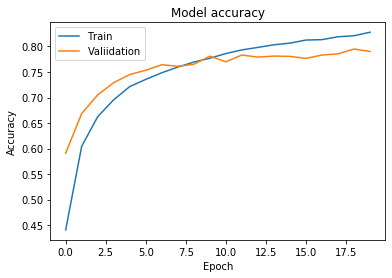

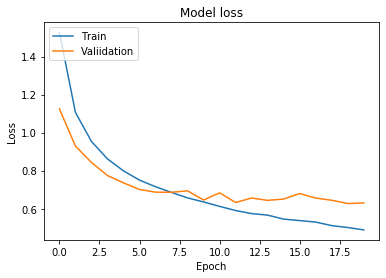

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

In [16]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model2 = Sequential()

#   第二步：構建網絡層
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model2.add(Activation('softmax')) # 最後一層用softmax作為激活函數

#第三步編譯
model2.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
if not data_augmentation:
    print('Not using data augmentation.')
    history=model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 76s 2ms/step - loss: 2.0811 - acc: 0.2286 - val_loss: 1.7782 - val_acc: 0.3747
Epoch 2/20
50000/50000 [==============================] - 73s 1ms/step - loss: 1.7321 - acc: 0.3689 - val_loss: 1.5882 - val_acc: 0.4218
Epoch 3/20
50000/50000 [==============================] - 121s 2ms/step - loss: 1.5675 - acc: 0.4291 - val_loss: 1.3985 - val_acc: 0.4981
Epoch 4/20
50000/50000 [==============================] - 135s 3ms/step - loss: 1.4322 - acc: 0.4795 - val_loss: 1.3007 - val_acc: 0.5379
Epoch 5/20
50000/50000 [==============================] - 145s 3ms/step - loss: 1.3465 - acc: 0.5162 - val_loss: 1.2309 - val_acc: 0.5538
Epoch 6/20
50000/50000 [==============================] - 140s 3ms/step - loss: 1.2689 - acc: 0.5450 - val_loss: 1.1394 - val_acc: 0.6017
Epoch 7/20
50000/50000 [==============================] - 138s 3ms/step - loss: 1.2137 -

In [18]:
# 建立一個有三層隱藏層之神經網路
def build_mlp():
    model = Sequential()

    #   第二步：構建網絡層
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
    model.add(Activation('softmax')) # 最後一層用softmax作為激活函數
    return model

In [24]:
opt_seq = ['Adam','Rmsprop']
for opt in opt_seq:
    model3 = build_mlp()
    model3.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print('now is training'+opt)
    if not data_augmentation:
        print('Not using data augmentation.')
        history=model3.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Using real-time data augmentation.')
        print('')

        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        history=model3.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)   

now is trainingAdam
Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 145s 3ms/step - loss: 1.4963 - acc: 0.4549 - val_loss: 1.1090 - val_acc: 0.5995
Epoch 2/20
50000/50000 [==============================] - 140s 3ms/step - loss: 1.0754 - acc: 0.6197 - val_loss: 0.9085 - val_acc: 0.6773
Epoch 3/20
50000/50000 [==============================] - 144s 3ms/step - loss: 0.9261 - acc: 0.6718 - val_loss: 0.8345 - val_acc: 0.7112
Epoch 4/20
50000/50000 [==============================] - 146s 3ms/step - loss: 0.8406 - acc: 0.7058 - val_loss: 0.7747 - val_acc: 0.7283
Epoch 5/20
50000/50000 [==============================] - 139s 3ms/step - loss: 0.7804 - acc: 0.7267 - val_loss: 0.7413 - val_acc: 0.7393
Epoch 6/20
50000/50000 [==============================] - 141s 3ms/step - loss: 0.7345 - acc: 0.7412 - val_loss: 0.6877 - val_acc: 0.7579
Epoch 7/20
50000/50000 [==============================] - 146s 3ms

In [25]:
## 超參數設定
LEARNING_RATE = 1e-2
EPOCHS = 20
BATCH_SIZE = [16,32,64,128,256]
MOMENTUM = 0.95

In [26]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.6f" % (bs))
    
    model4 = build_mlp()
    model4.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print('now is training '+opt)
    if not data_augmentation:
        print('Not using data augmentation.')
        history=model3.fit(x_train, y_train,
                  batch_size=bs,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
        train_loss = model4.history.history["loss"]
        valid_loss = model4.history.history["val_loss"]
        train_acc = model4.history.history["acc"]
        valid_acc = model4.history.history["val_acc"]
        exp_name_tag = "exp-bs-%s" % str(bs)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}
    else:
        print('Using real-time data augmentation.')
        print('')

        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        history=model4.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)   
        train_loss = model4.history.history["loss"]
        valid_loss = model4.history.history["val_loss"]
        train_acc = model4.history.history["acc"]
        valid_acc = model4.history.history["val_acc"]
        exp_name_tag = "exp-bs-%s" % str(bs)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with BATCH_SIZE = 16.000000
now is training Rmsprop
Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 85s 2ms/step - loss: 1.4594 - acc: 0.4703 - val_loss: 1.0731 - val_acc: 0.6273
Epoch 2/20
50000/50000 [==============================] - 84s 2ms/step - loss: 1.0745 - acc: 0.6178 - val_loss: 0.9519 - val_acc: 0.6688
Epoch 3/20
50000/50000 [==============================] - 84s 2ms/step - loss: 0.9351 - acc: 0.6706 - val_loss: 0.8659 - val_acc: 0.6956
Epoch 4/20
50000/50000 [==============================] - 81s 2ms/step - loss: 0.8568 - acc: 0.6992 - val_loss: 0.7876 - val_acc: 0.7294
Epoch 5/20
50000/50000 [==============================] - 81s 2ms/step - loss: 0.7875 - acc: 0.7237 - val_loss: 0.7668 - val_acc: 0.7345
Epoch 6/20
50000/50000 [==============================] - 79s 2ms/step - loss: 0.7443 - acc: 0.7389 - val_loss: 0.7530 - val_acc: 0.7415
Epoch 7/20
50000/50000 [=====

50000/50000 [==============================] - 184s 4ms/step - loss: 0.5614 - acc: 0.8020 - val_loss: 0.6406 - val_acc: 0.7868
Epoch 18/20
50000/50000 [==============================] - 188s 4ms/step - loss: 0.5530 - acc: 0.8065 - val_loss: 0.6613 - val_acc: 0.7764
Epoch 19/20
50000/50000 [==============================] - 184s 4ms/step - loss: 0.5340 - acc: 0.8117 - val_loss: 0.6556 - val_acc: 0.7814
Epoch 20/20
50000/50000 [==============================] - 182s 4ms/step - loss: 0.5304 - acc: 0.8138 - val_loss: 0.6537 - val_acc: 0.7797
Experiment with BATCH_SIZE = 128.000000
now is training Rmsprop
Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 185s 4ms/step - loss: 1.5396 - acc: 0.4370 - val_loss: 1.1147 - val_acc: 0.6005
Epoch 2/20
50000/50000 [==============================] - 183s 4ms/step - loss: 1.1206 - acc: 0.6020 - val_loss: 0.9242 - val_acc: 0.6791
Epoch 3/20
50000/50000 [======

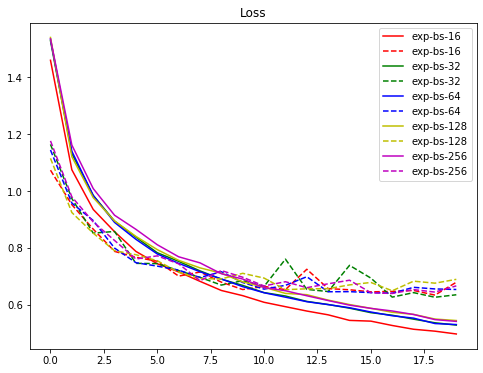

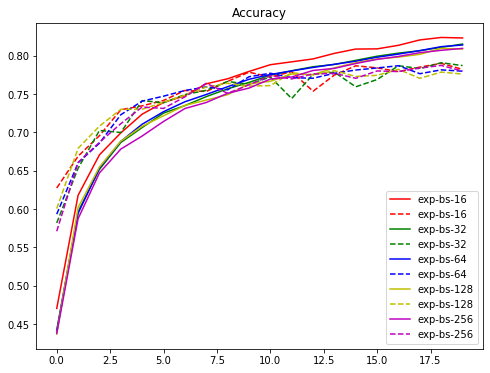

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()